In [1]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
%matplotlib inline

In [3]:
df = pd.read_csv('./Ethos_Dataset_Multi_Label.csv',sep=';')
df.columns

Index(['comment', 'violence', 'directed_vs_generalized', 'gender', 'race',
       'national_origin', 'disability', 'religion', 'sexual_orientation'],
      dtype='object')

In [4]:
df

,comment,violence,directed_vs_generalized,gender,race,national_origin,disability,religion,sexual_orientation
0,You should know women's sports are a joke,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,You look like Sloth with deeper Down’s syndrome,0.000000,0.833333,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,You look like Russian and speak like Indian. B...,1.000000,0.500000,0.142857,0.142857,0.714286,0.000000,0.000000,0.000000
3,"Women deserve to be abused, I guess.",0.666667,0.166667,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Women are made for making babies and cooking d...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
428,All people are fucked up because of these quee...,0.000000,0.000000,0.571429,0.000000,0.000000,0.000000,0.000000,0.571429
429,Actually THIS WEIRD PEOPLE are HARMFUL! They n...,0.000000,1.000000,0.000000,0.000000,0.333333,0.666667,0.000000,0.000000
430,ABU DA BI ABA DU BA BA HAMUD! See? I’m an arab...,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.857143,0.000000
431,a homo? so you fuck your brother instead of yo...,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [5]:
labels = ['violence', 'gender', 'race', 'national_origin', 'disability', 'religion', 'sexual_orientation']
text = df['comment']
label_df = df[labels]


In [6]:
def transform_labels(record):
    record = copy.deepcopy(record)
    _max  = record.argmax()
    for l, v in record.items():
        if l != record.index[_max]:
            record[l] = 0
        else:
            record[l] = 1
    return record

l_tmp = label_df.apply(transform_labels, axis=1)

In [7]:
l_tmp

,violence,gender,race,national_origin,disability,religion,sexual_orientation
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
428,0.0,1.0,0.0,0.0,0.0,0.0,0.0
429,0.0,0.0,0.0,0.0,1.0,0.0,0.0
430,0.0,0.0,0.0,0.0,0.0,1.0,0.0
431,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
l_tmp.isna().sum()

violence              0
gender                0
race                  0
national_origin       0
disability            0
religion              0
sexual_orientation    0
dtype: int64

In [9]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical


In [10]:
# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
max_sequence_length = 128

In [12]:
def preprocess_text_data(text_data, max_sequence_length):
    input_ids = []
    for text in text_data:
        tokens = tokenizer(text, padding='max_length', truncation=True, max_length=max_sequence_length, return_tensors="tf")['input_ids'][0]
        input_ids.append(tokens)
    return tf.convert_to_tensor(input_ids)

In [13]:
text_tokenized = preprocess_text_data(text, max_sequence_length)

In [14]:
text_tokenized.numpy()

array([[  101,  2017,  2323, ...,     0,     0,     0],
       [  101,  2017,  2298, ...,     0,     0,     0],
       [  101,  2017,  2298, ...,     0,     0,     0],
       ...,
       [  101,  8273,  4830, ...,     0,     0,     0],
       [  101,  1037, 24004, ...,     0,     0,     0],
       [  101,  1006,  1006, ...,     0,     0,     0]], dtype=int32)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(text_tokenized.numpy(), l_tmp, test_size=0.2, random_state=42)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((346, 128), (87, 128), (346, 7), (87, 7))

In [17]:
 y_train.shape

(346, 7)

In [18]:
## Model archi

num_classes = 7

input_text = Input(shape=(max_sequence_length,), dtype=tf.int32)

# Get BERT model's output
bert_output = bert_model(input_text)[0]

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

# Add fully connected layers with tanh activation
x = Dense(256, activation='tanh')(bert_output)
x = Flatten()(Dense(128, activation='tanh')(x))

# Add the output layer for classification
output = Dense(num_classes, activation='softmax')(x)

# Create a Keras model
model = Model(inputs=input_text, outputs=output)

# Compile the model with appropriate loss and optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [19]:
epochs=15
batch_size=32

# Train the model with dropout layers
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/15
10/10 [==============================] - 22s 712ms/step - loss: 5.4761 - accuracy: 0.1511 - val_loss: 4.4614 - val_accuracy: 0.1143
Epoch 2/15
10/10 [==============================] - 3s 300ms/step - loss: 2.9927 - accuracy: 0.2058 - val_loss: 2.5004 - val_accuracy: 0.2286
Epoch 3/15
10/10 [==============================] - 3s 299ms/step - loss: 1.9331 - accuracy: 0.3312 - val_loss: 2.1951 - val_accuracy: 0.1714
Epoch 4/15
10/10 [==============================] - 3s 345ms/step - loss: 1.4699 - accuracy: 0.4566 - val_loss: 2.5776 - val_accuracy: 0.2286
Epoch 5/15
10/10 [==============================] - 3s 305ms/step - loss: 1.1908 - accuracy: 0.5788 - val_loss: 2.2183 - val_accuracy: 0.1714
Epoch 6/15
10/10 [==============================] - 3s 301ms/step - loss: 0.9618 - accuracy: 0.7170 - val_loss: 2.2043 - val_accuracy: 0.1714
Epoch 7/15
10/10 [==============================] - 3s 304ms/step - loss: 0.7696 - accuracy: 0.7846 - val_loss: 2.0056 - val_accuracy: 0.2286
Epoch

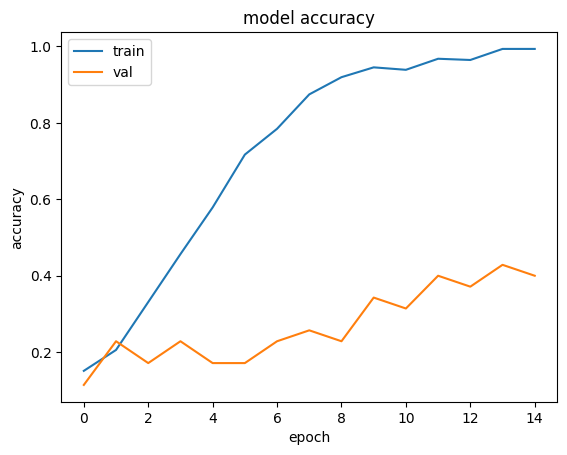

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

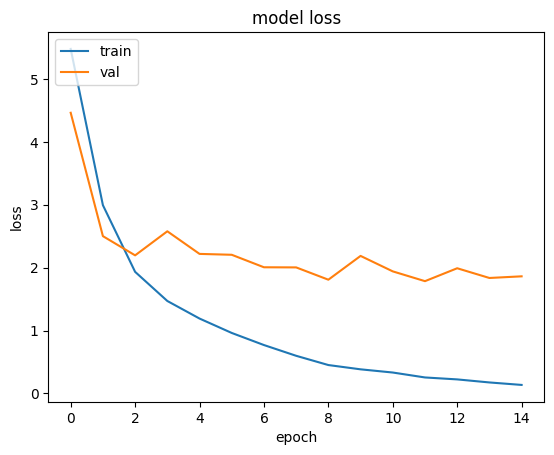

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
y_pred = model.predict(X_test)


3/3 [==============================] - 4s 223ms/step


In [23]:
threshold = 0.5  # Set your threshold value
y_pred_binary = (y_pred > threshold).astype(int)


In [24]:
from sklearn.metrics import multilabel_confusion_matrix

# Compute the confusion matrix
confusion_matrix = multilabel_confusion_matrix(y_test, y_pred_binary)
print(confusion_matrix)


[[[61 11]
  [10  5]]

 [[68  6]
  [ 9  4]]

 [[70  1]
  [14  2]]

 [[78  0]
  [ 9  0]]

 [[75  1]
  [ 8  3]]

 [[79  1]
  [ 3  4]]

 [[66  5]
  [16  0]]]


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

# List of confusion matrices for all 7 classes
confusion_matrices = [
    [[61, 11], [10, 5]],
    [[69, 5], [6, 7]],
    [[69, 2], [14, 2]],
    [[76, 2], [7, 2]],
    [[73, 3], [10, 1]],
    [[80, 0], [5, 2]],
    [[68, 3], [16, 0]]
]

# Calculate precision, recall, and F1-score for each class
for idx, confusion_matrix in enumerate(confusion_matrices, start=1):
    tn, fp = confusion_matrix[0]
    fn, tp = confusion_matrix[1]

    if tp + fp == 0 and tp + fn == 0:
        # Both precision and recall are 0, so assign F1-score as 0
        f1 = 0
    else:
        precision = tp / (tp + fp) if tp + fp != 0 else 0
        recall = tp / (tp + fn) if tp + fn != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

    print(f"Class {idx}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("-----------------------")


Class 1:
Precision: 0.3125
Recall: 0.3333333333333333
F1-score: 0.3225806451612903
-----------------------
Class 2:
Precision: 0.5833333333333334
Recall: 0.5384615384615384
F1-score: 0.5599999999999999
-----------------------
Class 3:
Precision: 0.5
Recall: 0.125
F1-score: 0.2
-----------------------
Class 4:
Precision: 0.5
Recall: 0.2222222222222222
F1-score: 0.30769230769230765
-----------------------
Class 5:
Precision: 0.25
Recall: 0.09090909090909091
F1-score: 0.13333333333333333
-----------------------
Class 6:
Precision: 1.0
Recall: 0.2857142857142857
F1-score: 0.4444444444444445
-----------------------
Class 7:
Precision: 0.0
Recall: 0.0
F1-score: 0
-----------------------


In [26]:
# Lists to store precision, recall, and F1-score for each class
precisions = []
recalls = []
f1_scores = []

# Calculate precision, recall, and F1-score for each class
for idx, confusion_matrix in enumerate(confusion_matrices, start=1):
    tn, fp = confusion_matrix[0]
    fn, tp = confusion_matrix[1]

    # Calculate precision, recall, and F1-score for the current class
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0

    # Append the calculated metrics to the lists
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Calculate macro-averaged precision, recall, and F1-score
macro_precision = sum(precisions) / len(precisions)
macro_recall = sum(recalls) / len(recalls)
macro_f1 = sum(f1_scores) / len(f1_scores)

print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1-score:", macro_f1)


Macro Precision: 0.4494047619047619
Macro Recall: 0.22794863866292436
Macro F1-score: 0.2811501043759108
